In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.19.1


In [2]:
from retrieve_sql_module import get_table

fangraphs_batting_stats_2024 = get_table("fangraphs_batting_stats_2024")

D:\jamin\baseball-projects\projections\hitting\scripts\retrieve_sql_module.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pbp_data = pd.concat(pbp_data_list, ignore_index=True)


In [3]:
fitting_subset = (
    fangraphs_batting_stats_2024
    .assign(
        label=lambda df: df["Name"].astype(str) + " - " + 
                         df["Season"].astype(str) + " - " + 
                         df["Team"].astype(str)
    )
)

In [4]:
fitting_subset

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label
0,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,238,0.609,391,0.146,0.267,0.315,0.742,0.484,11.3,Aaron Judge - 2024 - NYY
1,25764,2024,Bobby Witt Jr.,KCR,24,161,636,709,211,123,...,259,0.481,538,0.138,0.236,0.321,0.594,0.413,10.0,Bobby Witt Jr. - 2024 - KCR
2,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,287,0.595,482,0.144,0.269,0.320,0.678,0.448,9.0,Shohei Ohtani - 2024 - LAD
3,20123,2024,Juan Soto,NYY,25,157,576,713,166,90,...,262,0.568,461,0.189,0.263,0.319,0.658,0.463,8.2,Juan Soto - 2024 - NYY
4,26289,2024,Gunnar Henderson,BAL,23,159,630,719,177,102,...,256,0.539,475,0.167,0.265,0.289,0.505,0.379,7.7,Gunnar Henderson - 2024 - BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,6887,2024,Martin Maldonado,CHW,37,48,135,147,16,9,...,31,0.356,87,0.194,0.360,0.160,0.295,0.223,-1.3,Martin Maldonado - 2024 - CHW
636,15676,2024,Jose Abreu,HOU,37,35,113,120,14,10,...,28,0.326,86,0.173,0.298,0.162,0.241,0.199,-1.5,Jose Abreu - 2024 - HOU
637,20543,2024,Elehuris Montero,COL,25,67,224,247,46,32,...,71,0.415,171,0.132,0.290,0.212,0.338,0.274,-1.8,Elehuris Montero - 2024 - COL
638,12155,2024,Eddie Rosario,- - -,32,91,297,319,52,30,...,96,0.425,226,0.146,0.281,0.212,0.345,0.259,-2.3,Eddie Rosario - 2024 - - - -


In [5]:
fitting_subset['hr_rate'] = fitting_subset['HR'] / fitting_subset['PA']

In [6]:
fitting_subset.sort_values(by="hr_rate", ascending = False).head(5)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label,hr_rate
305,19273,2024,Stone Garrett,WSN,28,2,5,6,3,1,...,0.800,5,0.032,0.129,0.602,1.390,0.799,0.3,Stone Garrett - 2024 - WSN,0.166667
349,25448,2024,Greg Jones,COL,26,6,5,6,1,0,...,1.000,1,0.103,0.310,0.199,0.791,0.448,0.1,Greg Jones - 2024 - COL,0.166667
294,25705,2024,Dustin Harris,TEX,24,2,6,7,2,0,...,0.750,4,0.174,0.304,0.285,0.512,0.385,0.2,Dustin Harris - 2024 - TEX,0.142857
426,19928,2024,Ryan McKenna,- - -,27,13,14,15,3,1,...,0.444,9,0.115,0.212,0.169,0.383,0.260,-0.1,Ryan McKenna - 2024 - - - -,0.133333
239,27493,2024,Rece Hinds,CIN,23,24,46,51,12,2,...,0.400,30,0.114,0.310,0.254,0.625,0.396,0.6,Rece Hinds - 2024 - CIN,0.098039


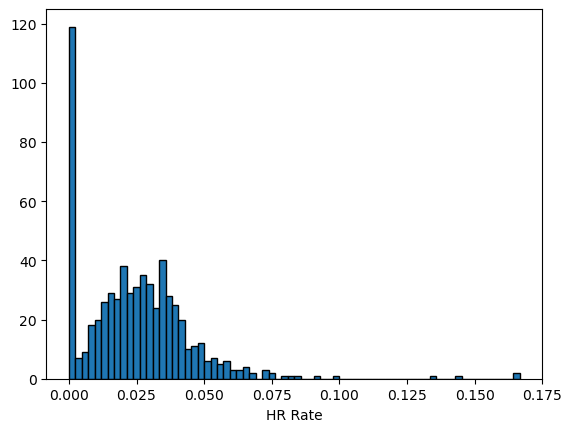

In [7]:
plt.hist(fitting_subset['hr_rate'].dropna(), bins = 70, edgecolor='black')
plt.xlabel("HR Rate")
plt.show()

In [8]:
pa, hr = fitting_subset[["PA", "HR"]].astype(np.int32).to_numpy().T
coords = {"batter":fitting_subset[['label']].to_numpy().squeeze()}

Uninformative model with p modeled as a uniform probability
$$
p_i \sim \text{Uniform}(0,1)
$$

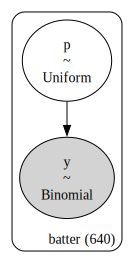

In [9]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform("p", 0, 1, dims = "batter")

    y = pm.Binomial("y", n = pa, p = p, observed = hr, dims="batter")
pm.model_to_graphviz(uninformative_prior_model)

In [10]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


In [11]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

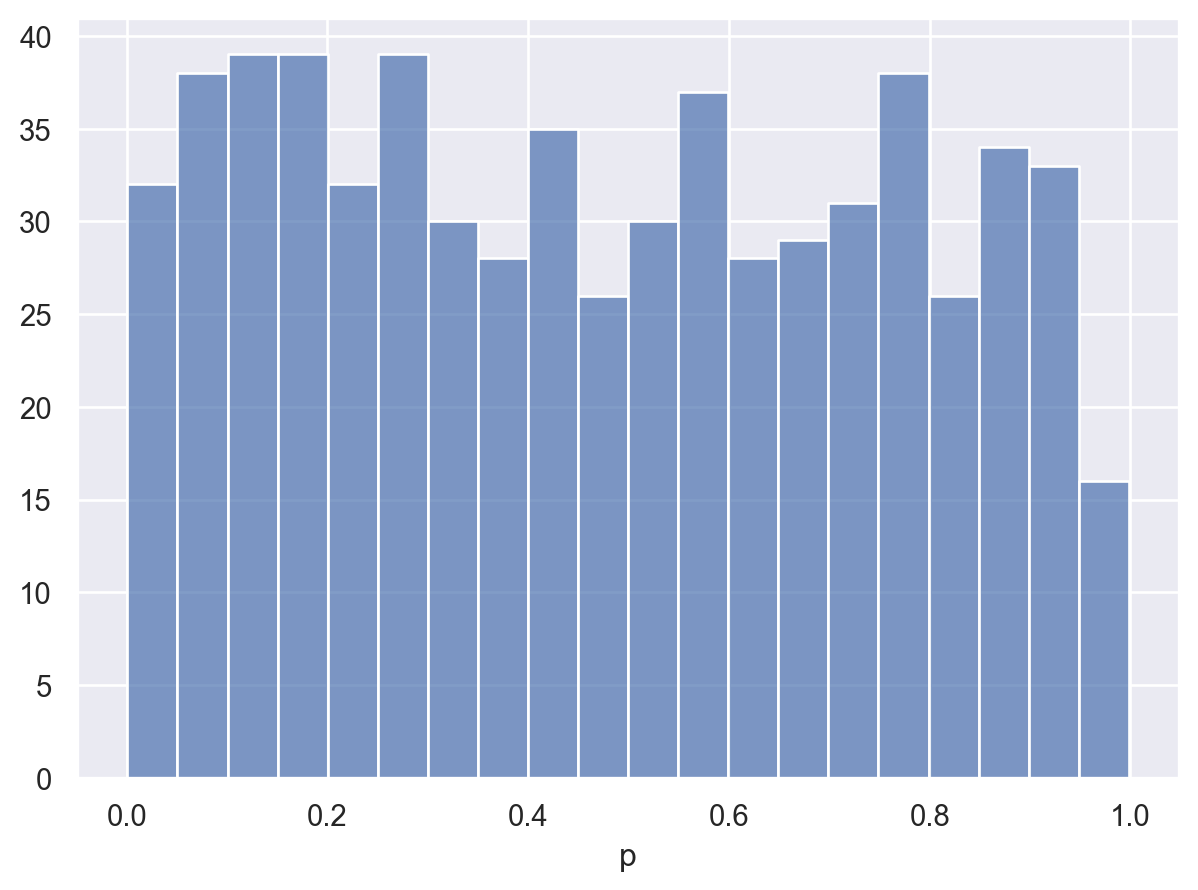

In [16]:
so.Plot(uninformed_prior_trace.prior['p'].sel(chain=[0], draw = [0]).squeeze()).add(so.Bars(), so.Hist(bins = 20))

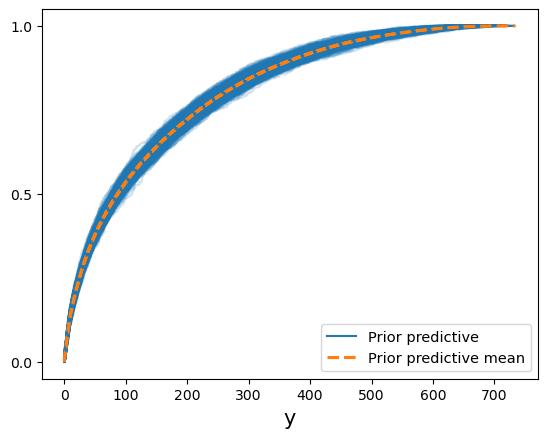

In [18]:
az.plot_ppc(uninformed_prior_trace, group = 'prior', kind = 'cumulative');

In [20]:
with uninformative_prior_model:
    trace = pm.sample(draws=100,tune = 100,cores =4, chains = 4, random_seed = RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
az.summary(trace).sort_values("r_hat", ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Jack Suwinski - 2024 - PIT],0.036,0.011,0.018,0.057,0.000,0.000,528.0,305.0,1.07
p[Adolis Garcia - 2024 - TEX],0.040,0.008,0.026,0.055,0.000,0.000,437.0,149.0,1.06
p[Paul DeJong - 2024 - - - -],0.052,0.010,0.037,0.072,0.001,0.000,318.0,139.0,1.06
p[Tyler O'Neill - 2024 - BOS],0.068,0.012,0.046,0.091,0.001,0.000,419.0,284.0,1.05
p[David Dahl - 2024 - PHI],0.063,0.030,0.017,0.122,0.002,0.001,332.0,169.0,1.05


In [26]:
with uninformative_prior_model:
    trace = pm.sample(draws = 1000, tune = 1000, cores = 4, chains = 4, random_seed = RANDOM_SEED)
uninformed_prior_trace.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<Axes: title={'center': 'p\nMookie Betts - 2024 - LAD'}, xlabel='Total number of draws', ylabel='ESS'>

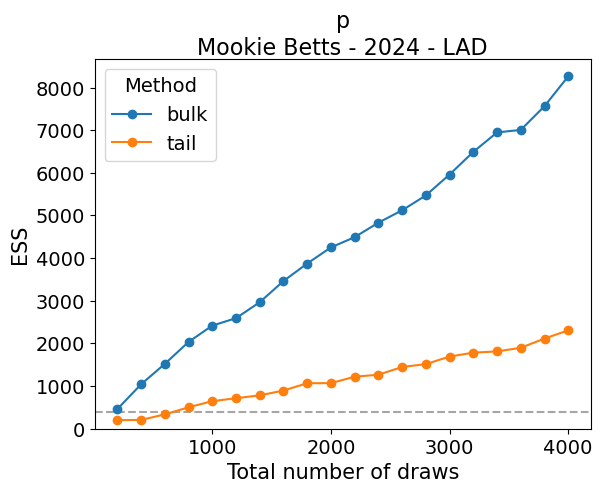

In [29]:
az.plot_ess(uninformed_prior_trace, var_names=["p"], coords ={"batter":["Mookie Betts - 2024 - LAD"]}, kind = "evolution")

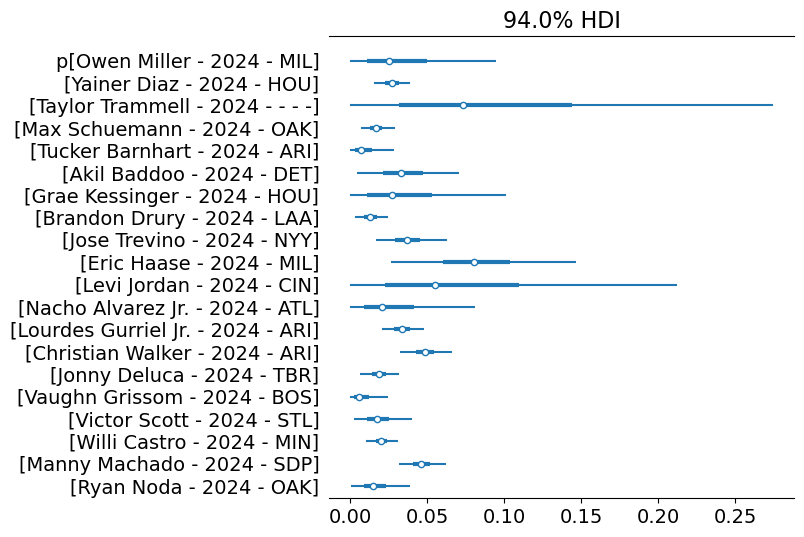

In [35]:
sampled_batters = fitting_subset.sample(n=20, random_state = 25555)

selected_data = sampled_batters[['label','hr_rate']]

SAMPLE_BATTERS,obs_rates = selected_data.to_numpy().T

(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":list(SAMPLE_BATTERS)}, combined = True)

In [36]:
uninformed_means = uninformed_prior_trace.posterior.mean(dim=("chain","draw"))
uninformed_hdi = az.hdi(uninformed_prior_trace)

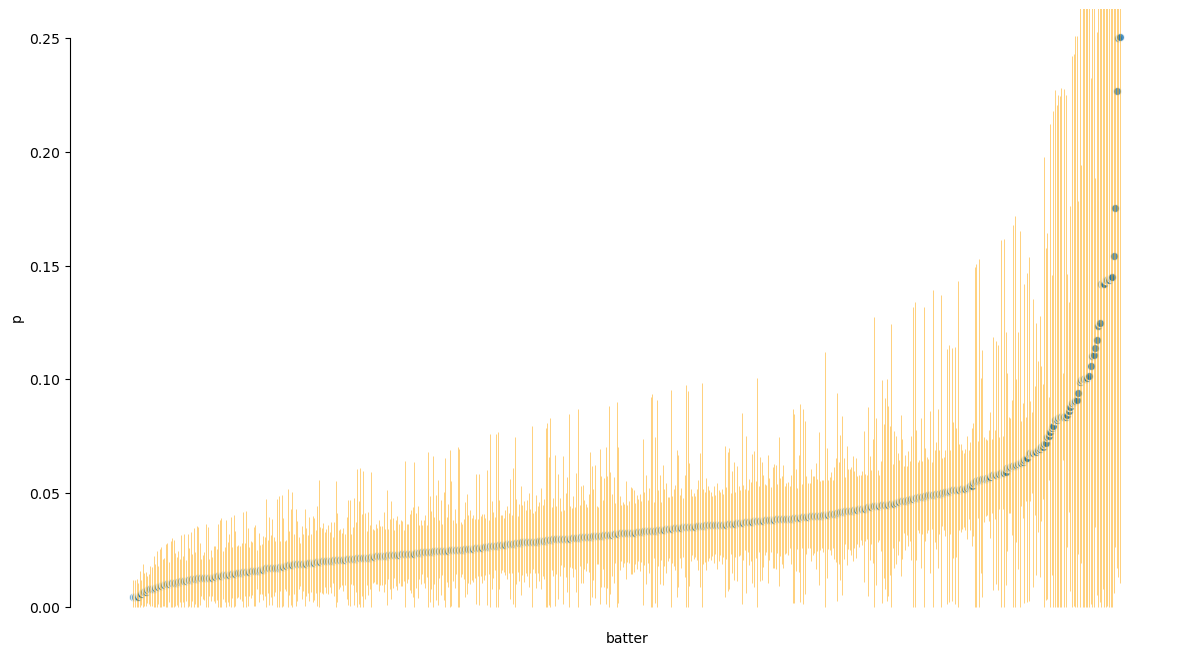

In [41]:
fig, ax = plt.subplots(figsize=(14,8))

uninformed_means_iter = uninformed_means.sortby("p")
uninformed_hdi_iter = uninformed_hdi.sortby(uninformed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    uninformed_hdi_iter.p.sel(hdi="lower"),
    uninformed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6
)
uninformed_means_iter.plot.scatter(x="batter", y = "p", ax=ax, alpha = 0.8)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10,trim=True,bottom=True)

Text(0, 0.5, 'Uncertainty of estimate')

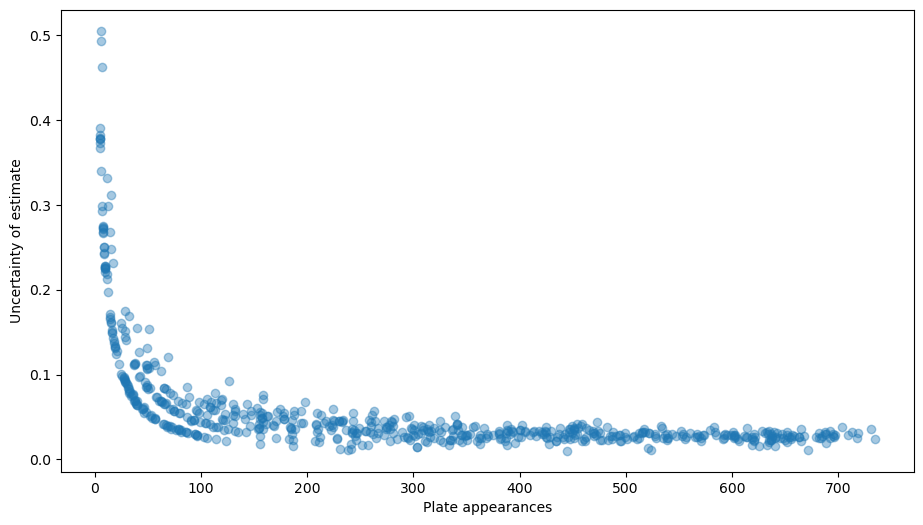

In [44]:
uncertainty = uninformed_hdi.p.sel(hdi="higher") - uninformed_hdi.p.sel(hdi = "lower")

plt.figure(figsize=(11,6))
plt.plot(pa, uncertainty, "o", alpha = 0.4)
plt.xlabel("Plate appearances")
plt.ylabel("Uncertainty of estimate")

Text(0.5, 0, 'Home Run Rate')

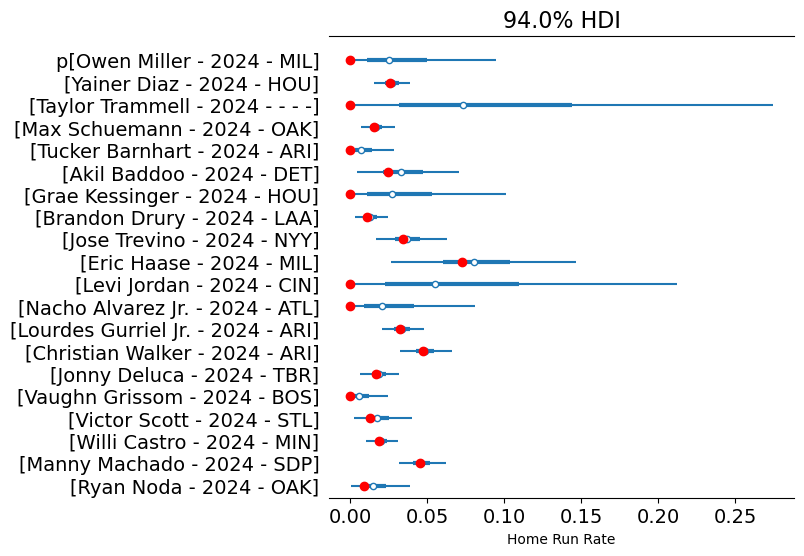

In [46]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":SAMPLE_BATTERS}, combined = True)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlabel("Home Run Rate")

In [47]:
with uninformative_prior_model:
    pm.sample_posterior_predictive(uninformed_prior_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y'>], dtype=object)

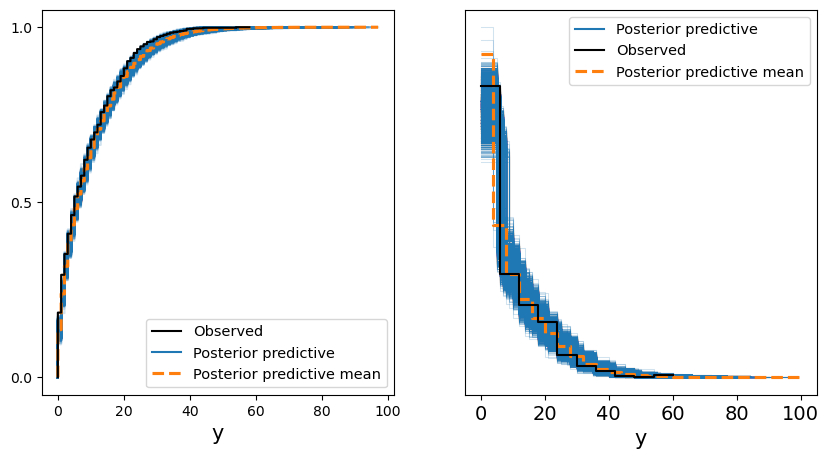

In [50]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
az.plot_ppc(uninformed_prior_trace, group = "posterior", kind = "cumulative", ax=axes[0])
az.plot_ppc(uninformed_prior_trace, group = "posterior", ax = axes[1])

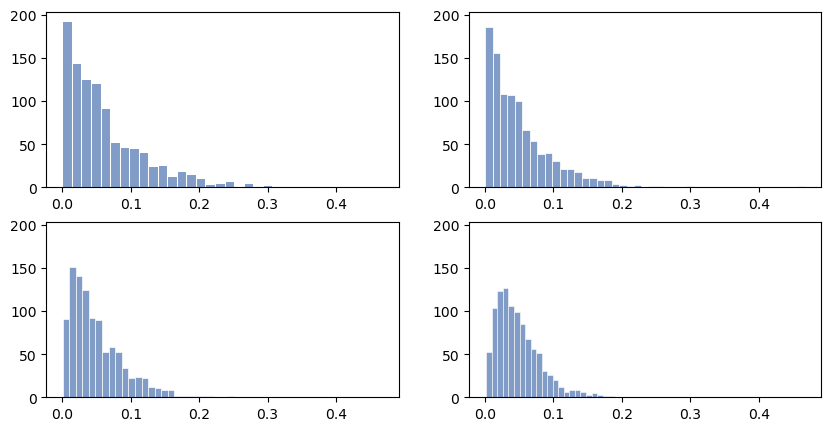

In [52]:
fig,axes = plt.subplots(2,2, figsize=(10,5), sharex=True, sharey=True)

for params, ax in zip([(1,15), (1,20), (1.5,30), (2,40)], axes.flat):
    so.Plot(pm.Beta.dist(*params, shape=1000).eval()).add(so.Bars(), so.Hist()).on(ax).plot()

In [53]:
pm.find_constrained_prior(
    pm.Beta,
    lower=0.01,
    upper=0.11,
    init_guess={"alpha" : 2, "beta" : 40}
)

C:\Users\jamin\AppData\Local\Temp\ipykernel_33452\1056268626.py:1: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  pm.find_constrained_prior(


{'alpha': 3.1375906600927745, 'beta': 60.55565032508642}

C:\Users\jamin\AppData\Local\Temp\ipykernel_33452\214001403.py:2: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  beta_params = pm.find_constrained_prior(


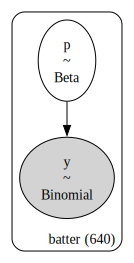

In [56]:
with pm.Model(coords=coords) as informative_prior_model:
    beta_params = pm.find_constrained_prior(
        pm.Beta,
        lower=0.05,
        upper=0.09,
        init_guess={"alpha": 2, "beta" : 40},
    )

    p = pm.Beta("p", **beta_params, dims="batter")

    y = pm.Binomial("y", n = pa, p = p, observed=hr, dims = "batter")

pm.model_to_graphviz(informative_prior_model)

In [57]:
with informative_prior_model:
    informed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: xlabel='y'>

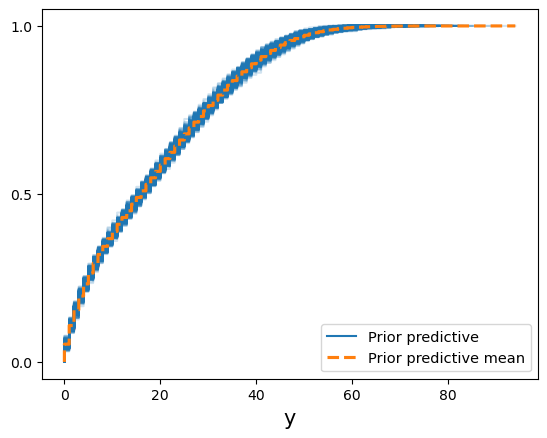

In [58]:
az.plot_ppc(informed_prior_trace, group = "prior", kind = "cumulative")

In [60]:
with informative_prior_model:
    informed_prior_trace.extend(pm.sample(cores=4, chains=4, random_seed = RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [62]:
informed_means = informed_prior_trace.posterior.mean(dim=("chain","draw"))
informed_hdi = az.hdi(informed_prior_trace)

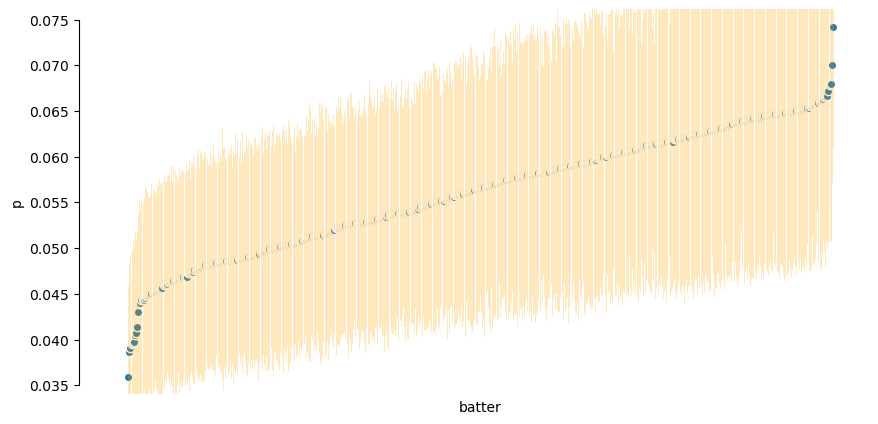

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

informed_means_iter = informed_means.sortby("p")
informed_hdi_iter = informed_hdi.sortby(informed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    informed_hdi_iter.p.sel(hdi="lower"),
    informed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.3,
    linewidth=0.6
)
informed_means_iter.plot.scatter(x="batter", y = "p", ax=ax)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True)